In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
import talib
%matplotlib inline
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
import numpy as np
from scipy.cluster.vq import kmeans,vq
import pandas_datareader as dr
from math import sqrt
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt


import warnings
warnings.filterwarnings('ignore')

In [84]:
ticker=['AAL','AAPL','ADBE','ADI','ADP','ADSK','ALGN','ALXN','AMAT','AMGN','AMZN','ASML','ATVI',
        'AVGO','BIDU','BIIB','BKNG','BMRN','CA','CDNS','CELG','CERN','CHKP','CHTR','CMCSA','COST',
        'CSCO','CSX','CTAS','CTRP','CTSH','CTXS','DLTR','EA','EBAY','ESRX','EXPE','FAST','FB','FISV',
        'FOX','FOXA','GILD','GOOG','GOOGL','HAS','HOLX','HSIC','IDXX','ILMN','INCY','INTC','INTU',
        'ISRG','JBHT','JD','KHC','KLAC','LBTYA','LBTYK','LRCX','MAR','MCHP','MDLZ','MELI','MNST',
        'MSFT','MU','MXIM','MYL','NFLX','NTES','NVDA','ORLY','PAYX','PCAR','PEP','PYPL','QCOM',
        'QRTEA','REGN','ROST','SBUX','SHPG','SIRI','SNPS','STX','SWKS','SYMC','TMUS','TSLA','TTWO',
        'TXN','ULTA','VOD','VRSK','VRTX','WBA','WDAY','WDC','WYNN','XLNX','XRAY']

In [85]:
print('Number of Companies:',len(ticker))

Number of Companies: 103


In [15]:
# Multiple
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf

yf.pdr_override() 

start = dt.datetime(2006,5,31)
end = dt.datetime(2018,12,20)

df = pdr.get_data_yahoo(ticker, start=start, end=end)

[*********************100%***********************]  103 of 103 downloaded


In [17]:
df.shape

(3163, 612)

In [23]:
fil_cols = [col for col in df.columns if 'Close' in col]
df1=df[fil_cols]
df1.columns = df1.columns.droplevel()
df1.to_csv('AllClose.csv')

## Data Read

In [2]:
df=pd.read_csv('AllClose.csv')
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
print(df.shape)
df.head(2)

(3163, 102)


,AAL,AAPL,ADBE,ADI,ADP,ADSK,ALGN,ALXN,AMAT,AMGN,...,ULTA,VOD,VRSK,VRTX,WBA,WDAY,WDC,WYNN,XLNX,XRAY
Date,,,,,,,,,,,,,,,,,,,,,
2006-05-30,44.610001,8.745714,28.350000,33.619999,35.957527,36.490002,7.37,8.0025,16.709999,66.830002,...,NaN,26.258919,NaN,32.619999,40.200001,NaN,20.049999,70.000000,25.43,29.645
2006-05-31,46.700001,8.538571,28.629999,33.730000,36.060623,36.389999,7.39,8.1275,16.910000,67.589996,...,NaN,26.794815,NaN,34.500000,40.599998,NaN,20.350000,71.199997,26.00,29.900


In [3]:
#Clustering on only training data
print(df.index.min()),print(df.index.max())
df=df.loc[:'2018-12-12',:]
print(df.shape)

2006-05-30 00:00:00
2018-12-19 00:00:00
(3158, 102)


In [4]:
df.dropna(axis=1,how='any', thresh=2500,inplace=True);
print(df.shape)

print(len(df.loc['2011-12-31':'2012-12-31','AAPL']))
print(len(df.loc['2012-12-31':'2013-12-31','AAPL']))
print(len(df.loc['2014-12-31':'2015-12-31','AAPL']))
#print(len(df.loc['2016-12-31':'2017-12-31','AAPL']))

(3158, 92)
250
253
253


In [5]:
#Calculate average annual percentage return and volatilities over a theoretical one year period
returns = df.pct_change().mean() * 252
returns = pd.DataFrame(returns)
#print(returns)
returns.columns = ['Returns']
returns['Volatility'] = df.pct_change().std() * sqrt(252)
#print(returns['Volatility'])
#format the data as a numpy array to feed into the K-Means algorithm
data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T
#removing NaN values, replacing them by 0
cleaned_data = np.where(np.isnan(data), 0, data)
#cleaned_data

In [6]:
cleaned_data.shape

(92, 2)

In [7]:
from sklearn.cluster import KMeans
X = cleaned_data
# Within cluster sum of squares. We calculate the sum of squares of the distance of each data point 
# in cluster k from their center point ki.

wcss = []
for k in range(2, 21):
    k_means = KMeans(n_clusters=k,init='k-means++', n_init=100, n_jobs=-1)
    k_means.fit(X)
    wcss.append(k_means.inertia_)

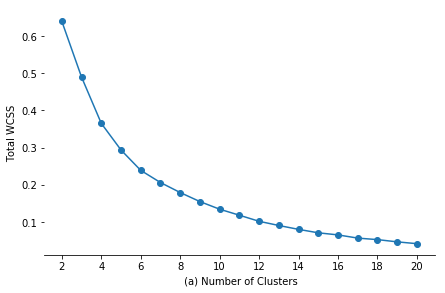

In [8]:
fig = plt.figure(figsize=(7, 4.5))
x=range(2,21)
plt.plot(range(2, 21), wcss,'o-')
plt.grid(False)
#plt.title('Elbow Curve')
plt.xlabel(" (a) Number of Clusters")
plt.ylabel("Total WCSS")
plt.xticks(np.arange(min(x), max(x)+1, 2))
sns.despine(left=True)
#plt.savefig('elbow.png', bbox_inches='tight', dpi=350)
plt.show()

In [9]:
k_means.inertia_

0.041990871271137174

In [10]:
# The change in slope of curve is not significant after k=4.
# Hence we select no. of clusters to be 4

# Computing K-Means with K = 4 (4 clusters)
centroids,_ = kmeans(cleaned_data,4)

# Assign each sample to a cluster
idx,_ = vq(cleaned_data,centroids)
 
data = cleaned_data

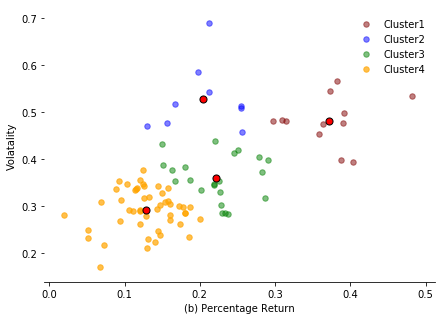

In [11]:
#Using Scatter plt 
plt.figure(figsize=(7,5))

plt.scatter(X[idx==0,0],X[idx==0,1],s=30,c='maroon',label='Cluster1',alpha=0.50)
plt.scatter(X[idx==1,0],X[idx==1,1],s=30,c='blue',label='Cluster2',alpha=0.50)
plt.scatter(X[idx==2,0],X[idx==2,1],s=30,c='green',label='Cluster3',alpha=0.50)
plt.scatter(X[idx==3,0],X[idx==3,1],s=30,c='orange',label='Cluster4',alpha=0.70)
#plt.scatter(X[idx==4,0],X[idx==4,1],s=30,c='gray',label='Cluster5',alpha=0.65)
#plt.scatter(k_means.cluster_centers_[:,0],k_means.cluster_centers_[:,1],s=300,c='yellow')
plt.scatter(centroids[:,0],centroids[:,1],s=50, c='red', alpha = 1, edgecolors='black')
sns.despine(left=True)
plt.xlabel('(b) Percentage Return')
plt.ylabel('Volatality')
plt.legend(loc='upperleft',frameon=False)
#plt.savefig('clusters.png', bbox_inches='tight', dpi=350)
plt.show()

In [12]:
#Finally to get the details of which stock is actually in which cluster we can run the following line

# of code to carry out a list comprehension to create a list of tuples in the (Stock Name, Cluster Number) format

details = [(name,cluster) for name, cluster in zip(returns.index,idx)]

In [13]:
labels =['Stock_Symbol', 'Cluster']
df1 = pd.DataFrame.from_records(details, columns=labels)
df1.head()

,Stock_Symbol,Cluster
0,AAL,1
1,AAPL,2
2,ADBE,2
3,ADI,3
4,ADP,3


In [14]:
df1.Cluster.unique()

array([1, 2, 3, 0], dtype=int64)

In [100]:
print(df1[df1.Stock_Symbol=='MSFT'])
print('\n')
df1[df1.Cluster==1].shape

   Stock_Symbol  Cluster
60         MSFT        3




(20, 2)

In [99]:
print(df1[df1.Stock_Symbol=='AAPL'])
print('\n')
df1[df1.Cluster==1].shape

  Stock_Symbol  Cluster
1         AAPL        1




(20, 2)

In [16]:
print(df1[df1.Stock_Symbol=='AMZN'])
print('\n')
df1[df1.Cluster==0].shape

   Stock_Symbol  Cluster
10         AMZN        0




(12, 2)

In [17]:
print(df1.iloc[10])
s=df1[df1.Cluster==0]
s.Stock_Symbol.values #Extracting Symbol Names

Stock_Symbol    AMZN
Cluster            0
Name: 10, dtype: object


array(['ALGN', 'AMZN', 'BIDU', 'BKNG', 'ILMN', 'INCY', 'MELI', 'NFLX',
       'NVDA', 'REGN', 'SWKS', 'ULTA'], dtype=object)

In [75]:
s=df1[df1.Cluster==1]
s.Stock_Symbol.values #Extracting Symbol Names

array(['ADI', 'ADP', 'AMAT', 'AMGN', 'CELG', 'CERN', 'CHKP', 'CMCSA',
       'COST', 'CSCO', 'CTAS', 'EA', 'EBAY', 'ESRX', 'FAST', 'FISV',
       'FOX', 'FOXA', 'GILD', 'GOOG', 'GOOGL', 'HAS', 'HOLX', 'HSIC',
       'INTC', 'INTU', 'JBHT', 'KLAC', 'LBTYA', 'LBTYK', 'MAR', 'MCHP',
       'MDLZ', 'MSFT', 'MXIM', 'MYL', 'PAYX', 'PCAR', 'PEP', 'QCOM',
       'SBUX', 'SHPG', 'SNPS', 'SYMC', 'TXN', 'VOD', 'WBA', 'XLNX',
       'XRAY'], dtype=object)

### Hierarchical

In [49]:
# Import hierarchical clustering libraries
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

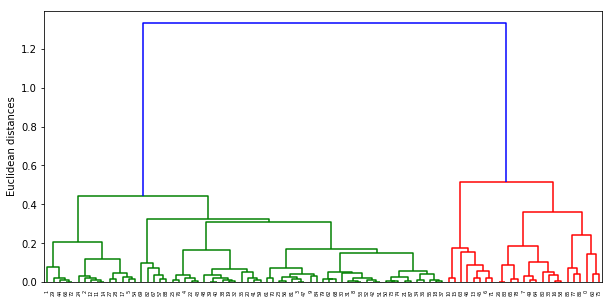

In [50]:
# create dendrogram
plt.figure(figsize=(10,5))
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
plt.ylabel('Euclidean distances');

In [56]:
# create clusters
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
y_hc = hc.fit_predict(X)

In [74]:
labels =['Stock_Symbol', 'Cluster']
df1=pd.DataFrame(list(zip(df.Stock_Symbol, y_hc)), columns=labels)

In [76]:
print(df1[df1.Stock_Symbol=='MSFT'])
print('\n')
df1[df1.Cluster==1].shape

   Stock_Symbol  Cluster
59         MSFT        1




(49, 2)

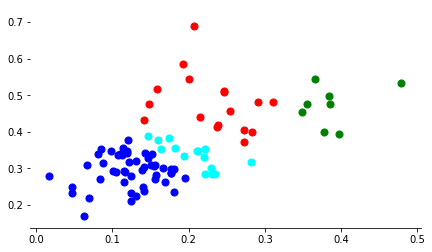

In [77]:
plt.figure(figsize=(7,4))

plt.scatter(X[y_hc ==0,0], X[y_hc == 0,1], s=50, c='red')
plt.scatter(X[y_hc==1,0], X[y_hc == 1,1], s=50, c='blue')
plt.scatter(X[y_hc ==2,0], X[y_hc == 2,1], s=50, c='green')
plt.scatter(X[y_hc ==3,0], X[y_hc == 3,1], s=50, c='cyan')
sns.despine(left=True)

### Clustering 3

In [78]:
X.shape

(89, 2)

In [129]:
dbsc = DBSCAN(eps = .5, min_samples = 15).fit(df)

In [131]:
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

In [140]:
X=cleaned_data
X.shape

(89, 2)

In [ ]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

### 3. DBSCAN

In [111]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.05, min_samples=2)
dbscan

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=2, n_jobs=None, p=None)

In [112]:
X=cleaned_data
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=2, n_jobs=None, p=None)

In [113]:
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 3


In [103]:
db1_labels=dbscan.labels_
db1_labels

array([-1, -1,  0,  0,  0,  0,  1,  2,  0,  0,  3,  0,  0,  1,  0,  3,  2,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  2,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, -1,  0,  0,  2,  0,
        0,  0,  0,  0,  0,  0,  5,  2,  0, -1,  0,  0, -1,  2,  6,  0,  5,
        0, -1,  0,  1,  0,  0,  0, -1,  0, -1,  6,  0, -1,  0, -1,  4,  0,
       -1, -1,  0,  5], dtype=int64)

In [123]:
len(db1_labels[db1_labels==5])

3

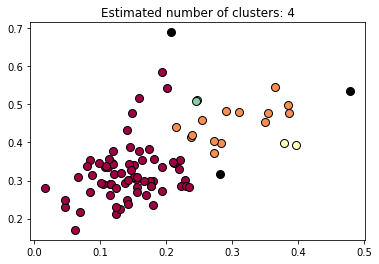

In [126]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=8)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=8)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [87]:
labels =['Stock_Symbol', 'Cluster']
df2=pd.DataFrame(list(zip(df.Stock_Symbol, dbscan.labels_)), columns=labels)

print(df2[df2.Stock_Symbol=='MSFT'])
print('\n')
df2[df2.Cluster==0].shape

   Stock_Symbol  Cluster
59         MSFT        0




(68, 2)

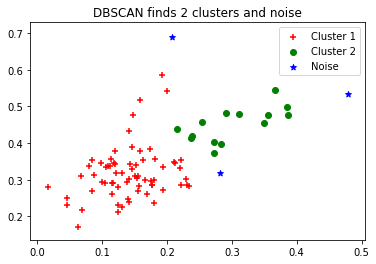

In [127]:
for i in range(0, X.shape[0]):
    if dbscan.labels_[i] == 0:
        c1 = plt.scatter(X[i,0],X[i,1],c='r',marker='+')
    
    elif dbscan.labels_[i] == 1:
        c2 = plt.scatter(X[i,0],X[i,1],c='g',marker='o')
    
    elif dbscan.labels_[i] == -1:
        c3 = plt.scatter(X[i,0],X[i,1],c='b',marker='*')

plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2','Noise'])
plt.title('DBSCAN finds 2 clusters and noise')
plt.show()